# TD(λ) (Temporal Difference with eligibility trace) in Continuous GridWorld
Given a "world" spanning from coordinates (0,0) to (10,10), train an agent to reach the goal while maximizing its rewards.

**Environment and state space**
* The ‘world’ has a continuous space, spanning from coordinates 0 to 10 along both the horizontal and vertical dimensions.
* The starting point is (2,2).
8 The agent cannot go outside of the grid.
* **Rewards**
    * **Trap:** Anywhere within the region (2,4) to (8,5) is the trap, in which the agent receives a reward of −50 for each step it takes in the trap.
    * **Goal:** Anywhere within the region (2,4) to (8,5) is the trap, in which the agent receives a reward of +100 once it reaches the goal and the episode terminates.
    * All moves which do not end in the goal or trap region will have a reward of −1, even if the agent tries to move off-grid.

**The agent**
* The agent can only move 1 unit distance per step in any direction in increments of 10 degrees. Therefore, there are 36 possible actions that the agent can take.
* The agent's moves are clipped to within the grid.
* Movement is deterministic.


In [1]:
import numpy as np
import pandas as pd
import math
import random
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict, deque, Counter
from prettytable import PrettyTable

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## 1. Implementing the environment
Create an environment class, which will include
1. `transition` function to calculate the rewards and position of the next state.
2. `reward` function to assign the reward at every step.
3. Other helper functions

In [2]:
# The environment
class ContinuousGridWorld:
    def __init__(self):
        self.world = [[0,0],[10,10]]    # [[begin_x,begin_y],[end_x,end_y]]
        self.initial_pos = [2,2]        # [x,y]
        self.dist = 1                   # Agent only allowed to move 1 unit distance
        self.goal = [[7,7],[8,8]]       # [[begin_x,begin_y],[end_x,end_y]]
        self.trap = [[2,4],[8,5]]       # [[begin_x,begin_y],[end_x,end_y]]
        self.trig_tolerance = 1e-15     # A small tolerance for considering the result of trigonometric calculations as 0
        self.num_actions = 36           # The agent has 36 possible actions in 10 degree increaments

    # Resets agent back to starting position
    def reset(self):
        self.is_done = False
        self.cur_state = deepcopy(self.initial_pos)
        return self.cur_state

    # Returns the number of dimensions of the grid
    def _get_state_dim(self):
        return len(self.world[0])

    # The agent has 36 possible actions in 10 degree increaments
    def _get_action_dim(self):
        return self.num_actions

    # Transition function to calculate rewards and position of next state
    def transition(self, state, action):
        if self.is_done:
            return 0, state, True

        # Agent can only move 1 unit distance. x = 1*cos(theta), y = 1*sin(theta)
        x = math.cos(action)
        y = math.sin(action)
        if abs(x) < self.trig_tolerance:
            x = 0
        if abs(y) < self.trig_tolerance:
            y = 0
        
        # Assuming moving 0 degrees always brings you north, clip the agent's coordinates so that it doesn't move out of the grid
        next_state_x = state[0] + (self.dist * x)
        next_state_x = np.clip(next_state_x, self.world[0][0], self.world[1][0])
        next_state_y = state[1] + (self.dist * y)
        next_state_y = np.clip(next_state_y, self.world[0][1], self.world[1][1])
        next_state = [next_state_x, next_state_y]

        # Define rewards
        # If goal is reached
        if (self.goal[0][0] <= next_state[0] <= self.goal[1][0]) and (self.goal[0][1] <= next_state[1] <= self.goal[1][1]):
            reward = 100
            self.is_done = True
        # If agent is in the trap
        elif (self.trap[0][0] <= next_state[0] <= self.trap[1][0]) and (self.trap[0][1] <= next_state[1] <= self.trap[1][1]):
            reward = -50
        # If agent is not in the goal or trap
        else:
            reward = -1

        return reward, next_state, self.is_done

## 2. Implementing the agent
This is were we implement an **all-in-one TD(λ) algorithm** which covers the following methods:
| TD Algorithm                     | On-Policy | $λ$        |
|:---------------------------------|:----------|:-----------|
| Monte Carlo                      | True      | $λ=1$      |
| SARSA (1-step TD)                | True      | $λ=0$      |
| Q-Learning                       | False     | $λ=0$      |
| General on-policy TD($\lambda$)  | True      | $0<λ<1$    |
| General off-policy TD($\lambda$) | False     | $0<λ<1$    |


Drawing inspiration from Deep Q-Learning (DQN), we implement **2 neural networks**
1. `Q_main`, the main network that we will train to predict $Q(S_t,A_t;\theta)$ (commonly referred to as $Q_{predicted}$). As training occurs at every step, we can expect fluctuations here.
2. `Q_target` the secondary network which we will use to predict $Q_t$ (commonly referred to as $Q_{target}$) which comprises of the immediate reward plus the discounted estimate of future returns obtainable from the next state until the agent reaches the goal. This network is not trained but rather, updated periodically (a soft update) with the learnt weights from Q_main to help it improve but with lesser fluctuations than Q_main.

Technically, we can obtain $Q_t$ and $Q(S_t,A_t;\theta)$ from the same network BUT since the network weights are updated every step, then, as $Q_t$ improves, $Q(S_t,A_t;\theta)$ will change (not necessarily improve) and we will literally be chasing a moving target with no end. Having 2 neural networks allows us to decouple $Q(S_t,A_t;\theta)$ and $Q_t$ to some extent for the calculation of mean squared error so that the training becomes more stable – an idea borrowed from Deep Q-Learning (DQN). 

That’s the TL;DR, and we highly recommend <a href="https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b">Reinforcement Learning Explained Visually (Part 5): Deep Q Networks</a> for a more in-depth explanation.

We create the following classes and their functions
1. `Net`, for the neural network.

2. `TemporalDifference`, the TD(λ) algorithm, which consists of the following functions
    1. `epsilon_greedy_policy`, our action selection strategy.
    2. `train` to train the agent and collect experience (episodes or steps) in a memory buffer.
        * For **Monte Carlo**,
            * Each successfully completed **episode** is stored in the memory buffer.
            * Because Monte Carlo requires the episode to be completed before learning, there is a chance that the agent gets stuck in the corner for too long and the episode never completes (there are infinite states in continuous state space).
            * Hence, we impose a limit to the number of steps the agent can take—if the agent has not reached the goal after >`steps_limit`, the episode is deemed to be a "poor" solution and should be discarded.
        * For **other TD methods** (not Monte Carlo), each **step** is stored in the memory buffer.
    3. `replay`, where once the agent gathers enough experience (i.e. when memory exceeds batch size), we sample a batch to update the Q network.
        * Q values are computed here, where
            * $Q_{target}(s,a) = [R_{t+1} + \gamma Q(s_{t+1}, a_{t+1})]\cdot E(s)$ when `on_policy=True`.
            * $Q_{target}(s,a) = [R_{t+1} + \gamma max_{a}{Q(s_{t+1}, a_{t+1})}]\cdot E(s)$ when `on_policy=False`.
            * $E(s)$ is the eligibility trace $\forall s\in S$, where $S$ is the set of previously visited states in the same episode.
        * The loss function is the mean squared error (MSE).

In [3]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Hidden layers. In this case, we will use 3 hidden layers.
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    # Feed forward
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class TemporalDifference:
    def __init__(self, Env, alpha=0.001, gamma=0.9, epsilon=0.1, lambd=0.9, batch_size=32):
        self.Env = Env
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.name = f"TemporalDifference(α = {self.alpha}, ɣ = {self.gamma}, ε = {self.epsilon}, λ = {self.lambd})"
        
        self.state_dim = self.Env._get_state_dim()      # Get dimensions of the state (in this case, state_dim=2 because the environment is 2D)
        self.action_dim = self.Env._get_action_dim()    # Get number of actions

        # Create two neural networks: Q_main and Q_target
        self.Q_main = Net(self.state_dim, self.action_dim)
        self.Q_target = deepcopy(self.Q_main)
        self.optimizer = optim.Adam(self.Q_main.parameters(), lr=self.alpha)

    # Action selection strategy
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)    # Explore by taking a random action
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                return torch.argmax(self.Q_main(state_tensor)).item()   # Exploit by taking the best action

    # Reset Q_main and Q_target
    def reset(self):
        self.Q_main = Net(self.state_dim, self.action_dim)
        self.Q_target = deepcopy(self.Q_main)
        self.optimizer = optim.Adam(self.Q_main.parameters(), lr=self.alpha)

    # Update Q_target (soft update)
    def _soft_update_Qtarget(self, tau=0.01):
        with torch.no_grad():
            for target_param, param in zip(self.Q_target.parameters(), self.Q_main.parameters()):
                target_param += tau * (param - target_param)

    # Update Q_main's weights, similar to backpropagation
    def _update_Qmain_weights(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self._soft_update_Qtarget()

    # Reset the episode if it gets too long
    def reset_episode(self):
        state = self.Env.reset()
        done = False
        step = 0
        episode_return = 0
        trace_dict = {} # For storing eligibility traces {(state's x coordinate, state's y coordinate, action): trace value}
    
        return state, done, step, episode_return, trace_dict
    
    # Train the agent
    def train(self, num_episodes, on_policy=True):
        memory = deque(maxlen=10_000)       # Memory of all episodes performed
        step_limit = 2_000                  # To limit the number of steps, so that we can kill the episode if the number of steps go out of hand. 

        # Iterate through episodes
        for _ in tqdm(range(num_episodes), desc="Episodes", position=0, leave=True):
            # Initialise by resetting
            state, done, step, episode_return, trace_dict = self.reset_episode()
            action = self.epsilon_greedy_policy(state)

            while not done and step < step_limit:
                reward, next_state, done = self.Env.transition(state, action)
                next_action = self.epsilon_greedy_policy(next_state)

                # Increment trace for current state
                trace_key = (state[0],state[1],action)
                if trace_key not in trace_dict:
                    trace_dict[trace_key] = 0
                trace_dict[trace_key] += 1
                trace = list(trace_dict.values())

                # Store in memory buffer
                memory.append((state, action, reward, next_state, next_action, done, trace))

                # Once there are sufficient samples in memory, randomly sample a batch to update Q network
                if len(memory) >= self.batch_size:
                    batch = random.choices(memory, k = self.batch_size)
                    self.replay(batch, on_policy)

                # Decay trace for past visited states
                trace_dict[trace_key] = (self.gamma**step) * (self.lambd**step)

                # Update state, action, episode_return, step
                state, action = next_state, next_action
                episode_return += reward
                step += 1
                
                # Discard the episode if the agent reaches the step_limit but is still unable to reach the goal (i.e. the agent is stuck)
                if step >= step_limit and not done:
                    print('Episode reset, agent stuck')
                    state, done, step, episode_return, trace_dict = self.reset_episode()
                    action = self.epsilon_greedy_policy(state)

    
    def replay(self, batch, on_policy):
        # Unpack batch and convert to required types
        states, actions, rewards, next_states, next_actions, dones, traces = zip(*batch)
        states = torch.tensor(states).to(torch.float32)
        actions = torch.tensor(actions).to(torch.int64)
        rewards = torch.tensor(rewards).to(torch.float32)
        next_states = torch.tensor(next_states).to(torch.float32)
        next_actions = torch.tensor(next_actions).to(torch.int64)
        dones = torch.tensor(dones).to(torch.int16)

        # Get next_q from Q_target
        if on_policy==True:
            # If acting on policy, get next_q from the next action taken
            next_q = self.Q_target(next_states)
            next_q = next_q.gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        else:
            # If NOT acting on policy, get next_q from the best possible next action
            next_q = self.Q_target(next_states).max(1)[0]

        targets = rewards + (self.gamma * next_q * (1 - dones))

        # Get current_q from Q_main
        current_q = self.Q_main(states)                                     # q values across all possible actions
        current_q = current_q.gather(1, actions.unsqueeze(-1)).squeeze(-1)  # Pick the q value for the corresponding action taken

        # Explode elibility traces to get the trace for that state
        traces = [torch.tensor(trace).to(torch.float32) for trace in traces]
        current_q = torch.cat([torch.mul(trace, q) for trace, q in zip(traces, current_q)])
        targets = torch.cat([torch.mul(trace, target) for trace, target in zip(traces, targets)])


        # Loss function: q_pred - q_target (where q_target = reward + gamma*next_q)
        loss = nn.MSELoss()(current_q, targets)

        # Update Q_main and perform soft update of Q_target
        self._update_Qmain_weights(loss)

## 4. Train the agents

### 4.1 Set the environment and training parameters

In [4]:
# Set the environment
env = ContinuousGridWorld()
training_episodes = 10_000

# For storing the agents in this format {agent name: (agent, on_policy)}
agents={}

### 4.2 Define the agents and train

In [5]:
# Case 1: Monte Carlo
agent_MC = TemporalDifference(env, alpha=0.001, gamma=0.99, epsilon=0.3, lambd=1)
agents['Monte Carlo'] = (agent_MC, True)
agent_MC.train(num_episodes=training_episodes)

Episodes:   0%|          | 22/10000 [00:32<5:51:14,  2.11s/it]

Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck


Episodes: 100%|██████████| 10000/10000 [13:40<00:00, 12.19it/s]


In [8]:
# Case 2: SARSA
agent_SARSA = TemporalDifference(env, alpha=0.001, gamma=0.99, epsilon=0.1, lambd=0)
agents['SARSA'] = (agent_SARSA, True)
agent_SARSA.train(num_episodes=training_episodes)

Episodes:   0%|          | 4/10000 [00:07<5:40:28,  2.04s/it]

Episode reset, agent stuck


Episodes:   0%|          | 50/10000 [01:11<2:34:07,  1.08it/s] 

Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck


Episodes:   1%|          | 56/10000 [01:45<5:27:54,  1.98s/it] 

Episode reset, agent stuck


Episodes: 100%|██████████| 10000/10000 [10:13<00:00, 16.30it/s]


In [55]:
# Case 3: Q-Learning
agent_QLearning = TemporalDifference(env, alpha=0.001, gamma=0.99, epsilon=0.1, lambd=0)
agents['Q-Learning'] = (agent_QLearning, False)
agent_QLearning.train(num_episodes=training_episodes, on_policy=False)

Episodes:   0%|          | 19/10000 [00:27<1:02:29,  2.66it/s]

Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck


Episodes:   0%|          | 22/10000 [01:25<22:47:16,  8.22s/it]

Episode reset, agent stuck


Episodes: 100%|██████████| 10000/10000 [15:37<00:00, 10.67it/s] 


In [14]:
# Case 4: General on-policy TD(λ)
agent_on_policy_TD = TemporalDifference(env, alpha=0.001, gamma=0.99, epsilon=0.1, lambd=0.5)
agents['On-Policy TD(λ)'] = (agent_on_policy_TD, True)
agent_on_policy_TD.train(num_episodes=training_episodes)

Episodes:   0%|          | 2/10000 [00:05<8:31:08,  3.07s/it]

Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck


Episodes:   0%|          | 3/10000 [03:09<238:11:44, 85.78s/it]

Episode reset, agent stuck
Episode reset, agent stuck


Episodes:   0%|          | 4/10000 [03:36<173:19:02, 62.42s/it]

Episode reset, agent stuck


Episodes:   0%|          | 5/10000 [03:59<134:26:21, 48.42s/it]

Episode reset, agent stuck


Episodes:   0%|          | 10/10000 [04:32<32:30:58, 11.72s/it]

Episode reset, agent stuck
Episode reset, agent stuck


Episodes: 100%|██████████| 10000/10000 [13:07<00:00, 12.69it/s]


In [26]:
# Case 5: General off-policy TD(λ)
agent_off_policy_TD = TemporalDifference(env, alpha=0.001, gamma=0.99, epsilon=0.1, lambd=0.5)
agents['Off-Policy TD(λ)'] = (agent_off_policy_TD, False)
agent_off_policy_TD.train(num_episodes=training_episodes, on_policy=False)

Episodes:   0%|          | 3/10000 [00:09<10:48:18,  3.89s/it]

Episode reset, agent stuck


Episodes:   1%|          | 105/10000 [01:59<4:57:30,  1.80s/it]

Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck
Episode reset, agent stuck


Episodes:   1%|          | 107/10000 [03:21<51:00:37, 18.56s/it]

Episode reset, agent stuck


Episodes: 100%|██████████| 10000/10000 [18:23<00:00,  9.07it/s] 


## 5 Test on 1000 episodes and visualise results

In [16]:
# Helper function to play a sample episode
def play_sample_episode(agent, env):
    state = env.reset()
    done = False
    path = [] # Keeps track of the states visited in the episode
    step, steps_trapped, total_reward = 0, 0, 0

    while not done:
        action = agent.epsilon_greedy_policy(state)
        path.append(state)
        reward, next_state, done = env.transition(state, action)
        if reward == -50:
            steps_trapped += 1
        total_reward += reward
        state = next_state
        step += 1

    # Append the terminal state
    path.append(state)

    return step, path, steps_trapped, total_reward

In [56]:
test_episodes = 1000
agents_results = {} # Store results in this format {(agent, episode): {'path':path, 'step':step, 'returns':returns}}

table = PrettyTable(["Agent", "Parameters", "Average Returns", "Average Steps Taken", "Average Steps in Trap"])
for key, value in agents.items():
    name = key
    agent = value[0]
    on_policy = value[1]
    # Create holders for results for each agent
    episodes, steps, paths, returns, trapped = [], [], [], [], []
    param = f'α={agent.alpha}, ɣ={agent.gamma}, ε={agent.epsilon}, λ={agent.lambd}, on_policy={on_policy}'
    for episode in range(test_episodes):
        step, path, steps_trapped, total_reward = play_sample_episode(agent, env)
        episodes.append(episode)
        steps.append(step)
        paths.append(path)
        returns.append(total_reward)
        trapped.append(steps_trapped)

        agents_results[(name, episode)] = {'path':path, 'step':step, 'returns':returns[episode], 'params':param}
    table.add_row([name, param, np.average(returns), np.average(steps), np.average(trapped)])

print(table)

+------------------+------------------------------------------------+-----------------+---------------------+-----------------------+
|      Agent       |                   Parameters                   | Average Returns | Average Steps Taken | Average Steps in Trap |
+------------------+------------------------------------------------+-----------------+---------------------+-----------------------+
|   Monte Carlo    |  α=0.001, ɣ=0.99, ε=0.3, λ=1, on_policy=True   |      79.542     |        17.636       |         0.078         |
|      SARSA       |  α=0.001, ɣ=0.99, ε=0.1, λ=0, on_policy=True   |      86.625     |        13.493       |         0.018         |
|    Q-Learning    |  α=0.001, ɣ=0.99, ε=0.1, λ=0, on_policy=False  |      83.672     |        14.192       |         0.064         |
| On-Policy TD(λ)  | α=0.001, ɣ=0.99, ε=0.1, λ=0.5, on_policy=True  |      84.098     |        15.334       |         0.032         |
| Off-Policy TD(λ) | α=0.001, ɣ=0.99, ε=0.1, λ=0.5, on_policy=

In [36]:
# Helper function to print paths for each agent
def plot_path(agent_name, episode_num=0):
    path = agents_results[agent_name, episode_num]['path']
    steps = agents_results[agent_name, episode_num]['step']
    episode_return = agents_results[agent_name, episode_num]['returns']
    params = agents_results[agent_name, episode_num]['params']

    width = 90
    print(f"{'#'*width}")
    print(f"Agent {agent_name:}".center(width))
    print(f"Episode {episode_num}".center(width))
    print(f"{'#'*width}")
    print(f"Number of steps: {steps} steps.")
    print(f"Total reward for the episode: {episode_return}.")
    
    x = [state[0] for state in path]
    y = [state[1] for state in path]
    
    # For plotting arrows to show each step the agent takes
    u, v = [], []
    for i in range(1,len(x)):
        u.append(x[i] - x[i-1])
        v.append(y[i] - y[i-1])
    u.append(0) # Add extra 0 to match the number of positions
    v.append(0) # Add extra 0 to match the number of positions

    # Plot world
    fig, ax = plt.subplots()
    ax.set_aspect('equal') # Sets a square grid
    ax.set_title(f"TemporalDifference({params})")
    ax.set_xlim(env.world[0][0], env.world[1][0])
    ax.set_ylim(env.world[0][1], env.world[1][1])
    # Plot goal
    g_width = env.goal[1][0] - env.goal[0][0]
    g_height = env.goal[1][1] - env.goal[0][1]
    ax.add_patch(plt.Rectangle((env.goal[0][0], env.goal[0][1]), g_width, g_height, color = 'yellow'))
    ax.annotate('G', (env.goal[0][0] + 0.5, env.goal[0][1] + 0.5), color='black', size=14, ha='center', va='center')
    # Plot trap
    t_width = env.trap[1][0] - env.trap[0][0]
    t_height = env.trap[1][1] - env.trap[0][1]
    ax.add_patch(plt.Rectangle((env.trap[0][0], env.trap[0][1]), t_width, t_height, color = 'grey'))
    ax.annotate('T', (env.trap[0][0] + 0.5, env.trap[0][1] + 0.5), size=14, ha='center', va='center')
    # Plot start
    ax.plot(env.initial_pos[0],env.initial_pos[1],'ro')
    ax.annotate('S', (env.initial_pos[0],env.initial_pos[1]), size=14, ha='center', va='center')

    # Plot steps: arrows at coordinates (x, y) with directions (u, v)
    ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1)

    plt.show()

##########################################################################################
                                    Agent Monte Carlo                                     
                                        Episode 40                                        
##########################################################################################
Number of steps: 14 steps.
Total reward for the episode: 87.


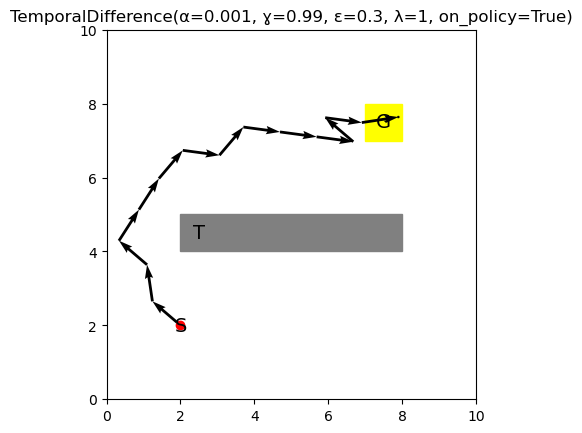

##########################################################################################
                                       Agent SARSA                                        
                                        Episode 40                                        
##########################################################################################
Number of steps: 18 steps.
Total reward for the episode: 83.


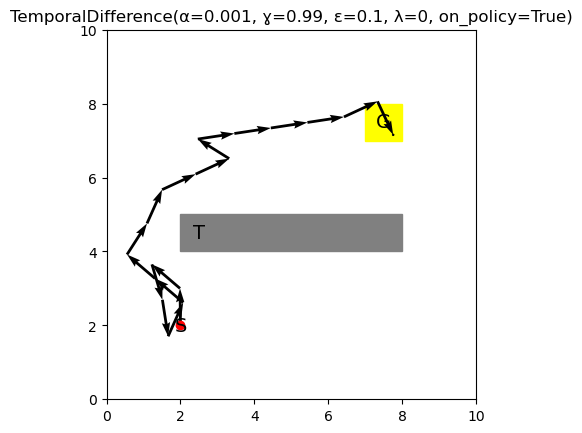

##########################################################################################
                                     Agent Q-Learning                                     
                                        Episode 40                                        
##########################################################################################
Number of steps: 11 steps.
Total reward for the episode: 90.


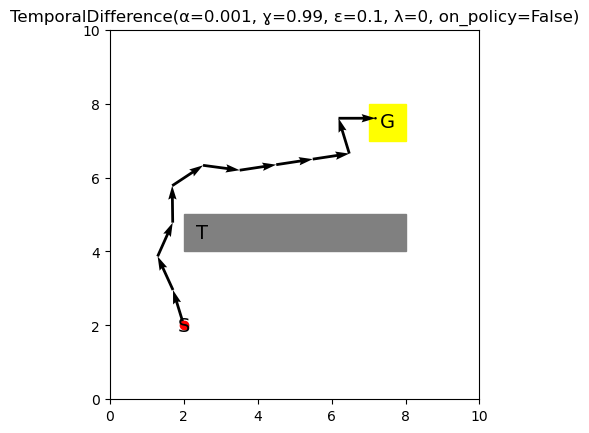

##########################################################################################
                                  Agent On-Policy TD(λ)                                   
                                        Episode 40                                        
##########################################################################################
Number of steps: 19 steps.
Total reward for the episode: 82.


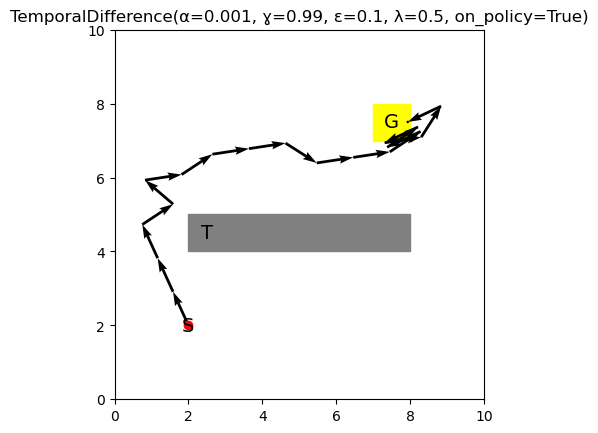

##########################################################################################
                                  Agent Off-Policy TD(λ)                                  
                                        Episode 40                                        
##########################################################################################
Number of steps: 12 steps.
Total reward for the episode: 89.


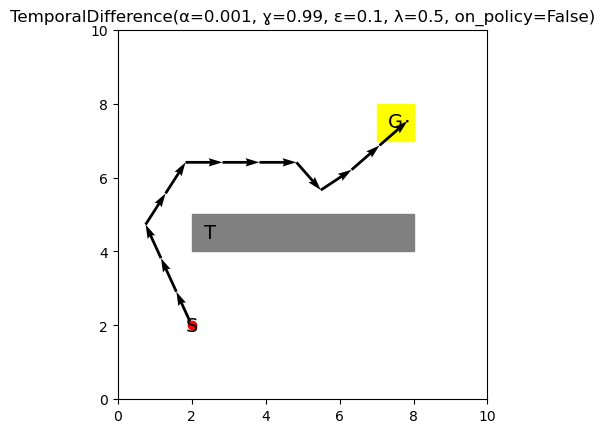

In [57]:
episode_num=40

for agent_name in agents.keys():
    plot_path(agent_name, episode_num)

## 6. References
Doshi, K (2020, December 20). Reinforcement learning explained visually (part 5): Deep Q networks, step-by-step. _Towards Data Science_. https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b.

Sutton, R. S., Barto, A. G. (2015). _Reinforcement learning: An introduction_. The MIT Press.